# Deep learning based inversion of locally anisotropic weld properties from Ultrasonic Array Data 

## Jonathan Singh, Katherine Tant, Anthony Mulholland, Charles MacLeod
## Applied Sciences, 2022

In [10]:
# load libraries 
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.keras as tfk
from multiprocessing import Process, Queue
from scipy.io import loadmat
from scipy import interpolate
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display

In [12]:
# import data

training_matlab = loadmat('training_data_subset.mat')

outputs_true = training_matlab['outputs']
inputs_true_center  = training_matlab['rec_time_center']
inputs_true_offset = training_matlab['rec_time_offset']
inputs_true_echo = training_matlab['rec_time_echo']



theta_mat = loadmat('theta_dense.mat')
thetai = theta_mat['thetai']

In [14]:
# note that the training data is only 1000 (memory limit for github)
np.shape(inputs_true_offset)

(1000, 32, 32)

In [15]:
inputs_true_offset = np.reshape(inputs_true_offset,(1000,1024))
inputs_true_center = np.reshape(inputs_true_center,(1000,1024))
inputs_true_echo = np.reshape(inputs_true_echo,(1000,1024))



# ogilvy orientations
inputs_offset = preprocessing.scale(inputs_true_offset)
inputs_center = preprocessing.scale(inputs_true_center)
inputs_echo   = preprocessing.scale(inputs_true_echo)

# inputs_wedge = preprocessing.scale(inputs_true_wedge)

outputs = (outputs_true-thetai)/10 #scale between -1 and 1  #scale this properly when i get background ogilvy model


# non random test train split 

# test_size = 0.1
x_train_center = inputs_center[100:1000,:] 
x_test_center = inputs_center[0:100,:]
y_train_center  = outputs[100:1000,:] 
y_test_center = outputs[0:100,:]


x_train_offset = inputs_offset[100:1000,:] 
x_test_offset = inputs_offset[0:100,:]
y_train_offset  = outputs[100:1000,:] 
y_test_offset = outputs[0:100,:]


x_train_echo = inputs_echo[100:1000,:] 
x_test_echo = inputs_echo[0:100,:]
y_train_echo  = outputs[100:1000,:] 
y_test_echo = outputs[0:100,:]



In [18]:
# configure network for pitch catch (Center)

netParams = [0.005, 3, 283, 46, 'sigmoid', 1000,0.0054] #optim for center
            
callbacks = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=20)


def create_model_center(outCellInd,learning_rate, num_dense_layers,num_input_nodes,
                 num_dense_nodes, activation, batch_size, adam_decay):
    #start the model making process and create our first layer
    model = Sequential()
    model.add(Dense(num_input_nodes, input_shape= (1024,), activation=activation
                   ))
    #create a loop making a new dense layer for the amount passed to this model.
    #naming the layers helps avoid tensorflow error deep in the stack trace.
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes,
                 activation=activation,
                        name=name
                 ))
    #add our classification layer.
    model.add(Dense(1))
    
    #setup our optimizer and compile
    adam = Adam(lr=learning_rate, decay= adam_decay)
    model.compile(optimizer=adam, loss='mae')
    
    history=model.fit(x=x_train_center,
                    y=y_train_center[:,outCellInd],
                    epochs=500,
                    callbacks=callbacks,
                    verbose=0,
                    batch_size=batch_size,
                    validation_split=0.2
                    )
    return model,history

In [19]:
# configure network for pitch catch (offset)

netParams = [0.002, 3, 220, 48, 'sigmoid', 1000,0.00443] #optim for offset 
callbacks = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=20)


def create_model_offset(outCellInd,learning_rate, num_dense_layers,num_input_nodes,
                 num_dense_nodes, activation, batch_size, adam_decay):
    #start the model making process and create our first layer
    model = Sequential()
    model.add(Dense(num_input_nodes, input_shape= (1024,), activation=activation
                   ))
    #create a loop making a new dense layer for the amount passed to this model.
    #naming the layers helps avoid tensorflow error deep in the stack trace.
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes,
                 activation=activation,
                        name=name
                 ))
    #add our classification layer.
    model.add(Dense(1))
    
    #setup our optimizer and compile
    adam = Adam(lr=learning_rate, decay= adam_decay)
    model.compile(optimizer=adam, loss='mae')
    
    history=model.fit(x=x_train_offset,
                    y=y_train_offset[:,outCellInd],
                    epochs=500,
                    callbacks=callbacks,
                    verbose=0,
                    batch_size=batch_size,
                    validation_split=0.2
                    )
    return model,history

In [20]:
# configure network for pulse echo

netParams = [0.0038824847512218914, 3, 303, 44, 'sigmoid', 1000,0.0045] #optim for echo
callbacks = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=20)


def create_model_echo(outCellInd,learning_rate, num_dense_layers,num_input_nodes,
                 num_dense_nodes, activation, batch_size, adam_decay):
    #start the model making process and create our first layer
    model = Sequential()
    model.add(Dense(num_input_nodes, input_shape= (1024,), activation=activation
                   ))
    #create a loop making a new dense layer for the amount passed to this model.
    #naming the layers helps avoid tensorflow error deep in the stack trace.
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes,
                 activation=activation,
                        name=name
                 ))
    #add our classification layer.
    model.add(Dense(1))
    
    #setup our optimizer and compile
    adam = Adam(lr=learning_rate, decay= adam_decay)
    model.compile(optimizer=adam, loss='mae')
    
    history=model.fit(x=x_train_echo,
                    y=y_train_echo[:,outCellInd],
                    epochs=500,
                    callbacks=callbacks,
                    verbose=0,
                    batch_size=batch_size,
                    validation_split=0.2
                    )
    return model,history

2.4912099838256836


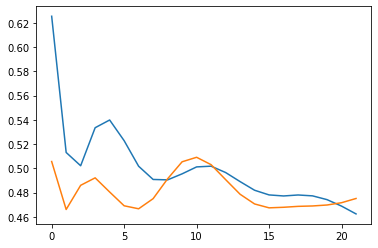

In [22]:
tic = time.time()

modelOut=create_model_center(90,netParams[0],netParams[1],netParams[2],netParams[3],netParams[4],netParams[5],netParams[6])
plt.plot(modelOut[1].history['loss'])
plt.plot(modelOut[1].history['val_loss'])

elapsed = time.time() - tic

print(elapsed)

In [ ]:
tic = time.time()

modelMat_center=[]
modelMat_offset=[]
modelMat_echo=[]

for i in range(0,91):
    
    print(i)
    modelOut=create_model_center(i,netParams[0],netParams[1],netParams[2],netParams[3],netParams[4],netParams[5],netParams[6])
    modelMat_center.append(modelOut)
    
    modelOut=create_model_offset(i,netParams[0],netParams[1],netParams[2],netParams[3],netParams[4],netParams[5],netParams[6])
    modelMat_offset.append(modelOut)
    
    
    modelOut=create_model_echo(i,netParams[0],netParams[1],netParams[2],netParams[3],netParams[4],netParams[5],netParams[6])
    modelMat_echo.append(modelOut)

    
elapsed = time.time() - tic
print(elapsed)

Text(0, 0.5, 'Validation MAE')

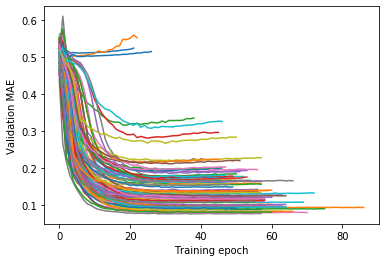

In [27]:
for i in range(0,91):
    val_hist =modelMat_center[i][1].history['val_loss'] 

    plt.plot(val_hist)
    
plt.xlabel('Training epoch')
plt.ylabel('Validation MAE')

Text(0, 0.5, 'Number of pixels')

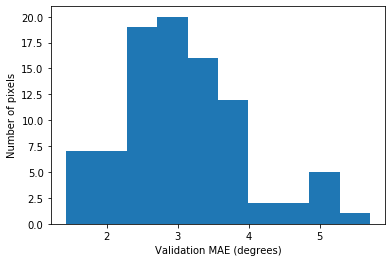

In [28]:
val_final = []

for i in range(0,91):
    val_final.append(modelMat_echo[i][1].history['val_loss'][-1]*10)
    
plt.hist(val_final)
plt.xlabel('Validation MAE (degrees)')
plt.ylabel('Number of pixels')

In [23]:
bMat_center=[]
bMat_offset=[]
bMat_echo=[]
tic = time.time()

for i in range(0,91):
    b = modelMat_center[i][0].predict(x_test_center)
    bMat_center.append(b)

    b = modelMat_offset[i][0].predict(x_test_offset)
    bMat_offset.append(b)
    
    b = modelMat_echo[i][0].predict(x_test_echo)
    bMat_echo.append(b)
    
elapsed = time.time() - tic
print(elapsed)    

12.443722009658813


In [30]:
bMat_offset= np.array(bMat_offset)
bMat_echo = np.array(bMat_echo)
bMat_center = np.array(bMat_center)

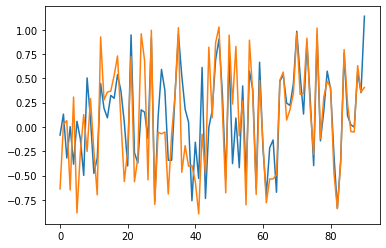

KeyboardInterrupt: 

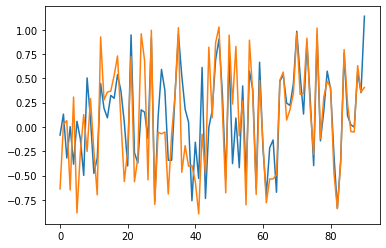

In [66]:

fig = plt.figure()

import time
import pylab as pl
from IPython import display

for i in range(100):

    xInd= i

    plt.plot(np.reshape(bMat_offset[:,xInd,:],[91,1]))
    plt.plot(y_test_offset[xInd,:])
    display.clear_output(wait=True) 
    display.display(pl.gcf())
    time.sleep(0.75)
    pl.clf()


In [39]:
# export 
from scipy.io import savemat

mdic = {"bMat_offset": bMat_offset, "bMat_center": bMat_center,"bMat_echo": bMat_echo,"y_test_center": y_test_center,"y_test_offset": y_test_offset,"y_test_echo": y_test_echo}
savemat("dense_param_predictions3.mat", mdic)
